# Práctica 1 - Self-Organising Maps
## Preparación de entorno
#### Instalar las librerías

In [23]:
# %pip install numpy
# %pip install matplotlib

#### Importar librerías de código

In [24]:
%reset
# from __future__ import division

import numpy as np
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import patches as patches
from itertools import product

# Permite que los gráficos sean interactivos en el notebook
%matplotlib inline

## SOM Setup
* **SOM** $\rightarrow$ Red neuronal no supervisada que reduce la dimensionalidad de los datos y los visualiza en un mapa 2D (Mapa autoorganizado).
  * Vector de entrada $\rightarrow$ Se le va presentando al SOM y ajusta sus pesos con estos vectores.
  * Autoorganización $\rightarrow$ Las neuroinas que repsonden de forma similar a cierta entrada se agrupan.
  * Aprendizaje y ajuste $\rightarrow$ Durante el entrenamiento, la red modifica los donde cada mapa se especializa en un patrón específico.
* **Matriz de pesos** $\rightarrow$ Matriz multidimensionl de neuronas que procesea patrones que vienen de un array de neuronas de entrada. 
  * Se inicializa con valores aleatorios (no a partir del vector de entrada, si no que se van ajustando a lo largo del entrenamiento).
* ***Best Matching Unit (BMU)*** $\rightarrow$ Neurona que tiene el vector de pesos más similar al vector de entrada. 
  * El aprendizaje se basa en la actualización de los pesos de la BMU y de las neuronas vecinas. 
  * Los pesos de la BMU se ajustan/actualizan para acercarse al vector de entrada.
* **Vecindad** $\rightarrow$ Neuronas adyacentes a la BMU (es una región de la matriz de pesos).
  * Las neuronas de la vecindad también se ajustan, pero en menor medida que la BMU.
* ***Learning Rate (LR)*** $\rightarrow$ Factor que determina cuánto se ajustan los pesos de la BMU y de las neuronas vecinas.
  * Se reduce a lo largo del tiempo para que el ajuste sea más preciso.
  * Disminuye a medida que nos alejamos de la BMU.

> *Nota* - El SOM aprende a ordenar la matriz de pesos para que reperesente la estructura inherente a los datos de entrada.

In [25]:
lado_mapa = 100
"""Tamaño del mapa de Kohonen (lado_mapa x lado_mapa)"""

periodo = 1000
"""Número total de iteraciones del entrenamiento"""

learning_rate = 0.05
"""Tasa de aprendizaje inicial (cuanto se modifica el peso en cada iteración)"""

normalizar_datos = True
"""Indica si hay que normalizar los datos o no"""

num_entradas = 3
"""Dimensionalidad de los datos de entrada (3 para RGB)"""

num_datos = 100
"""Cantidad de muestras de colores que usaremos para entrenar el SOM"""

valor_maximo = 255
"""Valor máximo de los datos de entrada (255 para RGB)"""

vecindario = lado_mapa // 2
"""Radio de influenia alrededor de la neurona ganadora"""

# Estructura -> minimo, maximo, (numero de colores por dato, numero de datos))
datos = np.random.randint(0, valor_maximo + 1, (num_entradas, num_datos))
"""Matriz de 100 colores con 3 valores RGB aleatorios"""

if normalizar_datos:
    # Escalamos los datos al rango [0, 1]
    datos = datos / np.max(valor_maximo)

matriz_pesos = np.random.random((lado_mapa, lado_mapa, num_entradas))
"""Matriz de pesos de las neuronas"""

'Matriz de pesos de las neuronas'

#### Funciones para entrenar/clasificar
##### Distancia euclídea

La distancia euclídea se define como la raíz cuadrada de la suma de las diferencias al cuadrado de cada componente de los vectores. Tenemos que calcularlo para vectores RGB, por lo que la fórmula es la siguiente:
$$\text{distancia euclídea} = \sqrt{(R_{entrada} - R_{actual})^2 + (G_{entrada} - G_{actual})^2 + (B_{entrada} - B_{actual})^2}$$

In [26]:
def calcular_bmu(patron_entrada, matriz_pesos, num_entradas) -> tuple:
   """Encuentra la BMU (neurona ganadora) para un patrón de entrada.

   Args:
      patron_entrada: Vector de entrada de color RGB normalizado
      matriz_pesos: Matriz de pesos de las neuronas del SOM
      num_entradas: Dimensionalidad de los datos de entrada (3 para RGB)

   Returns:
      tuple (bmu, bmu_idx):
         - bmu: vector de pesos de la neurona ganadora
         - bmu_idx: coordenadas [x,y] de la neurona ganadora
   """

   distancia_minima = float('inf')
   bmu = np.zeros(num_entradas)
   bmu_idx = np.zeros(2)

   # Recorremos cada neurona para encontrar la BMU
   # Filas -> matriz_pesos.shape[0]
   # Columnas -> matriz_pesos.shape[1]
   for fila in range(matriz_pesos.shape[0]):
      for columna in range(matriz_pesos.shape[1]):
         peso_actual = matriz_pesos[fila, columna]

         # Calculamos la distancia euclídea entre el peso actual y el patrón de entrada
         distancia = np.linalg.norm(patron_entrada - peso_actual)

         if distancia < distancia_minima:
            distancia_minima = distancia
            bmu = peso_actual
            bmu_idx = np.array([fila, columna])

   return bmu, bmu_idx

##### Learning Rate

El learning rate es un valor que se va reduciendo a medida que se va entrenando la red. Controla cuánto se modifican los pesos y determina el temaño del ajuste en los pesos de las neuronas. Se calcula usando una función de decaimiento lineal:
$$\alpha(t) = \alpha_0 \cdot \left ( 1 - \frac{t}{T} \right)$$

Donde:
* $\alpha_0$: Learning rate inicial.
* $t$: Iteración actual.
* $T$: Número total de iteraciones.
* $\alpha(t)$: Learning rate en la iteración $t$.

¿Porque usamos el decaimiento lineal?:
1. **Fase inicial:**
   * El learning rate comienza en su valor máximo ($\alpha_0$).
   * La reducción es constante y predecible.
   * Los ajustes son proporcionalmente grandes.
   * Permite que hagamos modificaciones significativas en el mapa.
2. **Fase media:**
    * Descenso uniforme del learning rate.
    * Los cambios en los pesos son más pequeños.
    * Los ajustes son proporcionales al tiempo que ha pasado.
    * El mapa comienza a estabilizarse.
3. **Fase final:**
   * Learning rate se aproxima a 0.
   * Los ajustes se vuelven muy pequeños.
   * Los cambios son mínimos al final del entrenamiento.
   * El mapa tiene a una configuración final estable.


In [27]:
def variacion_learning_rate(learning_rate_inicial, iteracion_actual, num_iteraciones) -> float:
   """Calcula el Learning Rate (eta) para  la iteración actual utilizando el decaimiento lineal.

   Args:
      learning_rate_inicial: Learning rate inicial
      iteracion_actual: Iteración actual
      num_iteraciones: Número total de iteraciones

   Returns:
      float: Learning rate actualizado para la iteración actual
   """

   return learning_rate_inicial * ( 1 - (iteracion_actual / num_iteraciones))

##### Vecindario

El vencindario es una región de influencia alrededor de la neurona ganadora que determina qué otrsa neuronas se actualizarán y en que medida. Es como una zona de impacto y también se calcula usando la función de decaimiento lineal:
$$\sigma(t) = 1 + \left ( \sigma_0 \cdot \left (1 - \frac{t}{T} \right) \right)$$

Donde:
* $\sigma_0$: Radio inicial del vecindario.
* $t$: Iteración actual.
* $T$: Número total de iteraciones.
* $\sigma(t)$: Radio del venciandario en la iteración $t$.

> *Nota* -> Añadimos el 1 para evitar que el radio del vecindario sea 0 en algún momento.

¿Porque usamos el decaimiento lineal?:
1. **Fase inicial:**
   * El vecindario comienza en su valor máximo ($\sigma_0$).
   * Afecta a un gran número de neuronas vecinas.
   * Permite que hagamos una organización global del mapa.
   * Facilita que distribuyamos inicialmente las características.
2. **Fase media:**
    * Reducimos constantemente el radio del vecindario.
    * Vamos disminuyendo la influencia gradualmente.
    * Formamos estructuras locales más definidas.
    * Los ajustes son más precisos y específicos.
3. **Fase final:**
   * El radio del vecindario se acerca linelamente a 0.
   * Los ajustes son en un área muy pequeña.
   * Se ajustan los últimos detalles.
   * La influencia está practicamente limitada a la BMU.


In [28]:
def variacion_vecindario(vecindario_inicial, iteracion_actual, num_iteraciones) -> float:
   """Calcula el radio del vecindario para la iteración actual.

   Args:
      vecindario_inicial: Radio inicial del vecindario
      iteracion_actual: Iteración actual
      num_iteraciones: Número total de iteraciones

   Returns:
      float: Vecindario actualizado para la iteración actual
   """

   return 1 + (vecindario_inicial * ( 1 - (iteracion_actual / num_iteraciones)))

##### Decay (Amortiguación)

El decay es una función que determina cómo se amortigua el learning rate según la distancia entre una neurona y la BMU (neurona ganadora). Se calcula usando una función gaussiana:

$$h(d,\sigma) = e^{-\frac{d^2}{2\sigma^2}}$$

Donde:
* $d$: Distancia entre la neurona y la BMU
* $\sigma$: Radio actual del vecindario
* $h(d,\sigma)$: Factor de amortiguación

¿Por qué usamos una función gaussiana?:
1. **Centro (BMU)**:
   * Distancia = 0
   * Máxima influencia ($\approx 1$)
   * Mayor ajuste de pesos

2. **Neuronas cercanas**:
   * Distancia pequeña
   * Influencia moderada
   * Ajuste proporcional a la cercanía

3. **Neuronas lejanas**:
   * Distancia grande
   * Influencia mínima ($\approx 0$)
   * Casi no se modifican

In [29]:
def decay(distancia_BMU, vecindario_actual) -> float:
   """Calcula la amortiguación de eta en función de la distancia en el mapa entre una neurona y la BMU.

   Args:
      distancia_BMU: Distancia entre la neurona y la BMU
      vecindario_actual: Radio actual del vecindario

   Returns:
      float: Factor de amortiguación para la iteración (Está entre 0 y 1)
   """
   return np.exp(-distancia_BMU / (2 * (vecindario_actual**2)))

#### Funciones para dibujar la salida de la red

In [30]:
def pintar_mapa(matriz_valores, titulo):
    """Función para pintar una matriz de valores como colores RGB.
    Visualiza el mapa de Kohonen, donde cada neurona se representa como un rectángulo de color RGB.

    Args:
        matriz_valores: Matriz de valores RGB (lado_mapa x lado_mapa x 3)
        titulo: Titulo del mapa
    """

    # Creamos una nueva figura
    fig = plt.figure()

    # Establecemos los ejes
    ax = fig.add_subplot(111, aspect='equal') # aspect='equal' mantiene cuadrados los rectángulos
    ax.set_xlim((0, matriz_valores.shape[0]+1)) # Limites del eje x
    ax.set_ylim((0, matriz_valores.shape[1]+1)) # Limites del eje y
    ax.set_title(titulo)

    # Dibujamos los rectángulos por cada neurona (Un cuadrado RGB)
    for fila in range(1, matriz_valores.shape[0] + 1):
        for columna in range(1, matriz_valores.shape[1] + 1):
            ax.add_patch(patches.Rectangle(
                (fila - 0.5, columna - 0.5),                           # Posición (x,y) del rectángulo
                1, 1,                                                  # Ancho y alto del rectángulo
                facecolor = matriz_valores[fila - 1, columna - 1, :],  # Color RGB del rectángulo
                edgecolor = 'none'                                     # Sin borde
            ))

    plt.show()

## SOM Entrenamiento

El entrenamiento de un SOM es un proceso de aprendizaje no supervisado en el que una red de neuronas ajusta sus pesos para representar la distribución de los datos de entrada. Este proceso se basa en la competencia y la cooperación entre las neuronas de la red.

1. **Inicialización de los pesos**:
   * Cada neurona en el mapa tienen un vector de pesos asociado.
   * Los pesos se inicializan con valores aleatorios.
   * Los vectores de pesos deben tener la misma dimensión que los vectores de entrada.
   * Los pesos se ajustan durante el entrenamiento.

2. **Búsqueda de la BMU**:
   * En cada iteración, presentamos un vector de entrada a la red y calculamos qué neurona tiene los pesos más similares a este vector.
   * Esta neurona se conoce como la Best Matching Unit (BMU).
   * La BMY se encuentra minimizando la distancia euclídea entre el vector de entrada y los vectores de pesos de las neuronas.

3. **Ajuste de los pesos**:
    * Una vez que hemos encontrado la BMU, ajustamos los pesos de la BMU y de las neuronas vecinas para que se acerquen al vector de entrada.
    * La BMU se ajusta más que las neuronas vecinas.
    * La magnitud del ajuste depende del learning rate y del vecindario.

4. **Actualización del learning rate y del vecindario**:
    * El learning rate y el vecindario se actualizan en cada iteración.
    * Ambos se reducen a lo largo del tiempo para que el ajuste sea más preciso.
    * El learning rate y el vecindario se calculan usando funciones de decaimiento lineal.
    * Esto nos permite que al principio del entrenamiento se hagan ajustes grandes y globales y al final se hagan ajustes pequeños y locales.

5. **Convergencia**:
    * Después de muchas iteraciones, el SOM se organiza de forma que los pesos reflectan la estructura de los datos de entrada.
    * Las regiones del mapa que representan patrones similares están más cerca.

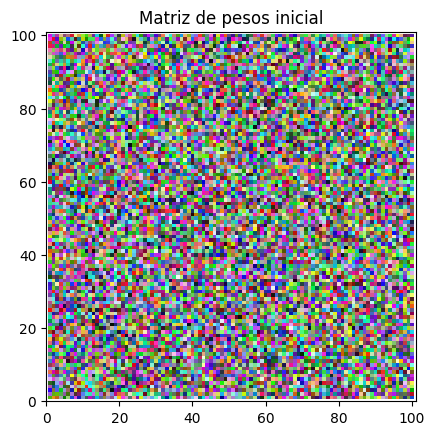

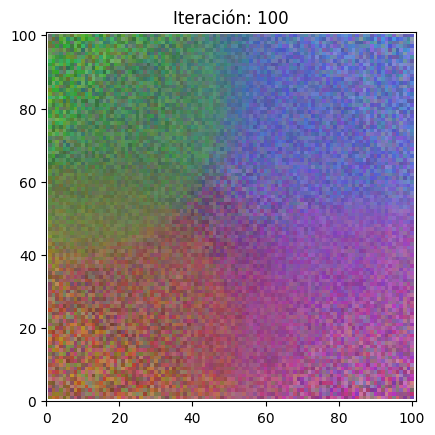

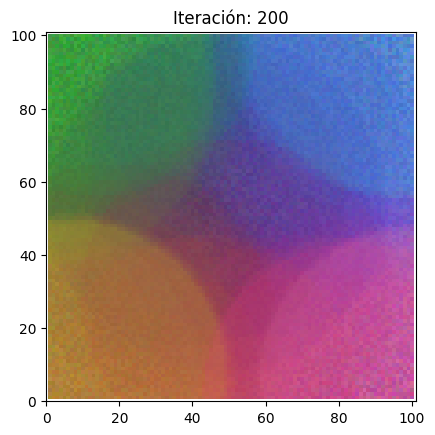

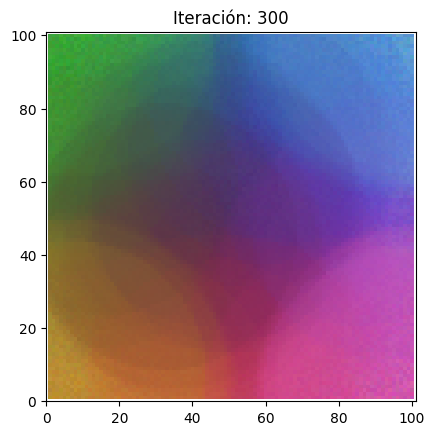

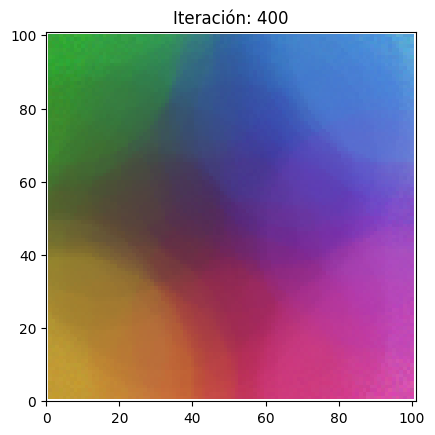

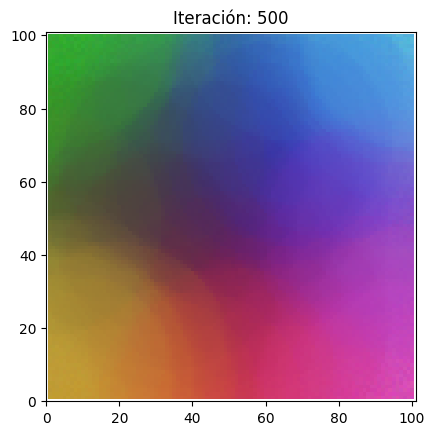

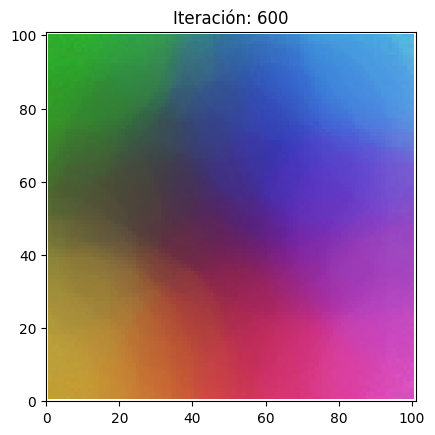

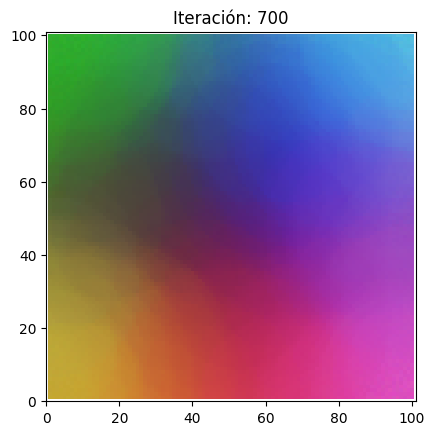

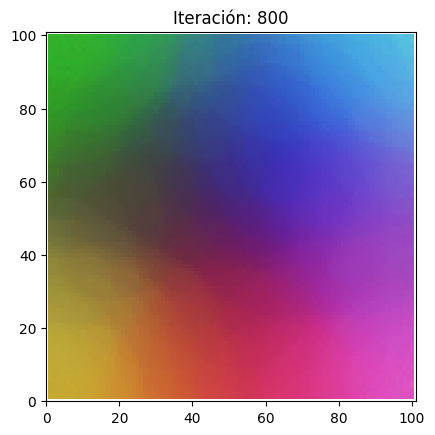

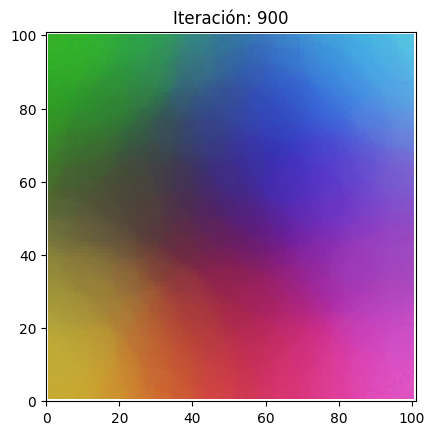

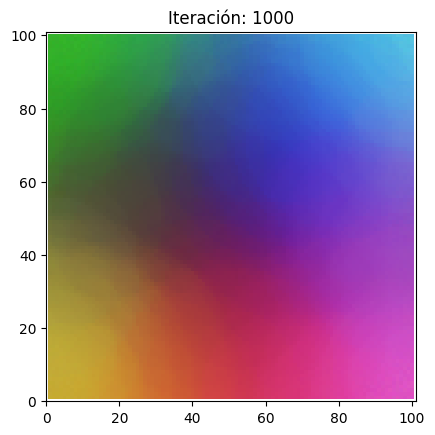

In [31]:

def entrenar_datos(matriz_pesos, periodo, datos, num_datos, num_entradas, learning_rate, vecindario) -> np.array:
    """Entrena el mapa de Kohonen con los datos de entrada.

    Args:
        matriz_pesos: Matriz de pesos de las neuronas del SOM
        periodo: Número total de iteraciones del entrenamiento
        datos: Datos de entrada (3 x num_datos)
        num_datos: Número de datos de entrada
        num_entradas: Dimensionalidad de los datos de entrada (3 para RGB)
        learning_rate: Tasa de aprendizaje inicial
        vecindario: Radio de influencia alrededor de la neurona ganadoras

    Returns:
        np.array: Matriz de pesos de las neuronas del SOM entrenadas
    """

    # Pintamos la matriz de pesos inicial
    pintar_mapa(matriz_pesos, "Matriz de pesos inicial")

    # Entrenamiento del SOM
    for epoca in range(periodo + 1):
        # Seleccionamos un patrón de entrada aleatorio
        patron_azar = datos[:, np.random.randint(0, num_datos)]

        # Buscamos la BMU para el patrón de entrada
        neurona_bmu, bmu_indice = calcular_bmu(patron_azar, matriz_pesos, num_entradas)

        # Calculamos los parámetros para esta iteración
        lr_actual = variacion_learning_rate(learning_rate, epoca, periodo)
        vec_actual = variacion_vecindario(vecindario, epoca, periodo)

        # Actualizamos el vector de pesos de la BMU y sus vecinos
        for fila in range(matriz_pesos.shape[0]):
            for columna in range(matriz_pesos.shape[1]):
                # Calculamos la distancia a la BMU
                distancia_bmu = np.linalg.norm([fila - bmu_indice[0], columna - bmu_indice[1]])

                if distancia_bmu <= vec_actual:
                    # Calculamos la amortiguación basada en la distancia
                    amortiguacion = decay(distancia_bmu, vec_actual)

                    # Actualizamos los pesos usando la fórmula
                    matriz_pesos[fila, columna] += lr_actual * amortiguacion * (patron_azar - matriz_pesos[fila, columna])

        if epoca % 100 == 0 and epoca != 0:
            # Pintamos la matriz de pesos
            pintar_mapa(matriz_pesos, f"Iteración: {epoca}")

    return matriz_pesos

matriz_pesos_inicial = np.copy(matriz_pesos)
matriz_pesos_entrenada = entrenar_datos(matriz_pesos, periodo, datos, num_datos, num_entradas, learning_rate, vecindario)

#### Evaluación de los parámetros
Para evaluar la mejor combinación de parámetros de la red, vamos a usar el conjunto de datos de entrenamiento y vamos a entrenar la red con diferentes valores de los parámetros. Vamos a usar la función de error de cuantificación y el error topológico para evaluar la calidad de la red. 
* **Error cuantificación** $\rightarrow$ Mide la distancia media entre cada vector de entrada y su neurona ganadora en el mapa. Cuanto menor sea el error, mejor será la capacidad de nuestro SOM para representar los datos de entrada.
* **Error topológico** $\rightarrow$ Mide cuántos pares de vectores que son vecinos en el conjunto de datos originales, permanecen vecinos en el mapa. Cuanto más bajo sea, mejor se preserva la estructura de los datos originales.

Fórmula del error de cuantificación: $$EQ = \frac{1}{N} \sum_{i=1}^{N} d(x_i, w_{BMU_i})$$

Fórmula del error topológico: $$TE = \frac{1}{N} \sum_{i=1}^{N} \sum_{j=1}^{N} d_{ij} \cdot \delta_{ij}$$

Tras evaluar los parámetros y escoger aquellos que minimizan el error de cuantificación y el error topológico, hemos encontrado los siguientes valores óptimos:
```md
Mejores parámetros encontrados:
* Lado del mapa: 50
* Periodo: 5000
* Learning rate: 0.05
* Error de cuantificación: 0.0897
* Error topológico: 0.0300
```

![Comparacion valores](./media/comparación_mejores_valores.png)

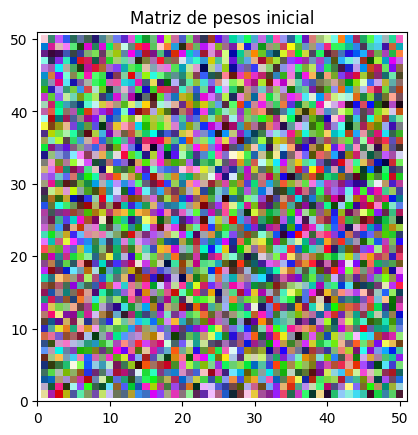

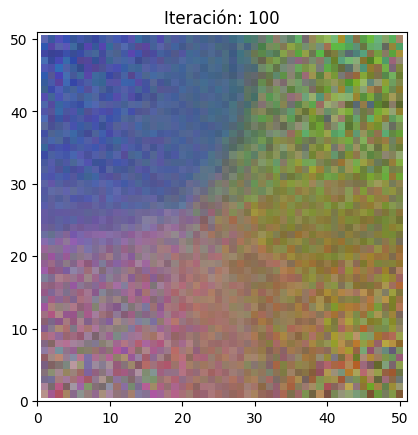

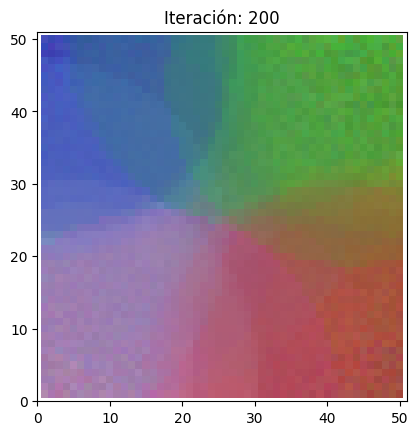

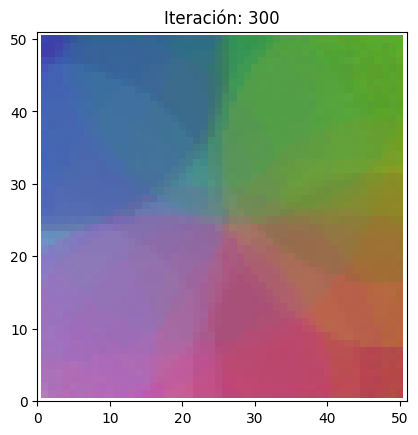

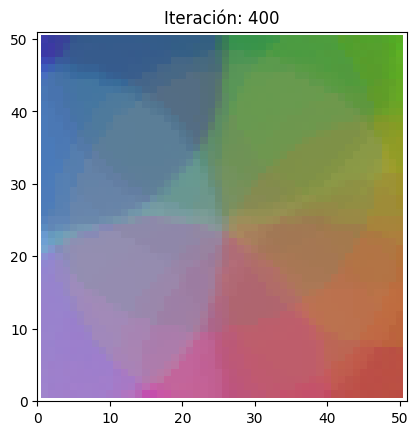

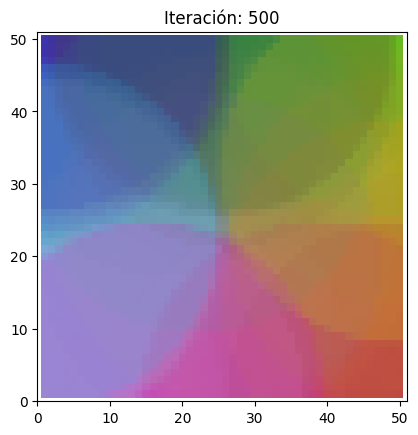

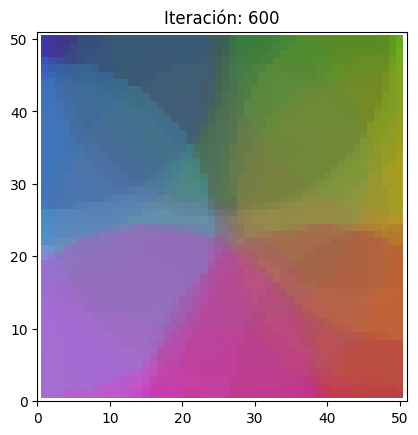

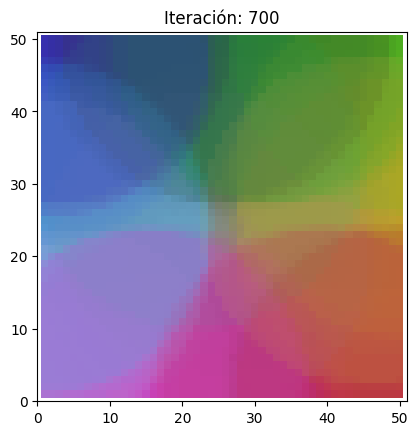

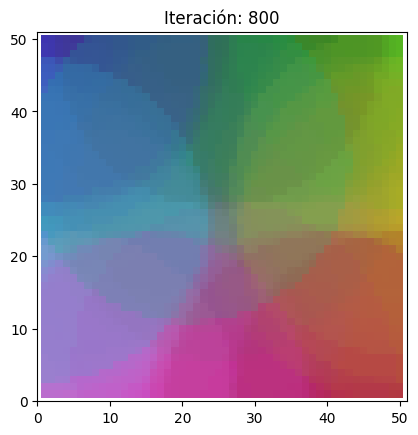

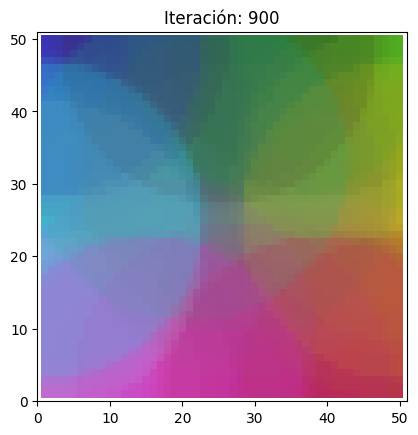

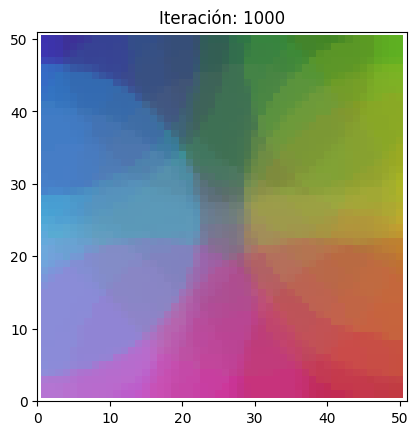

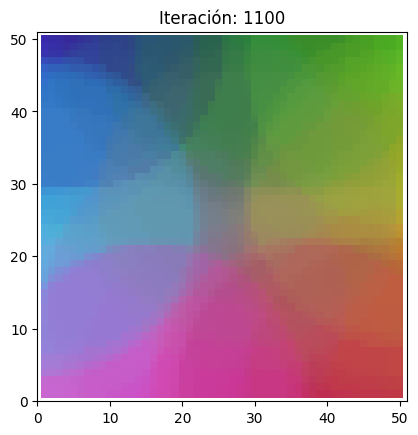

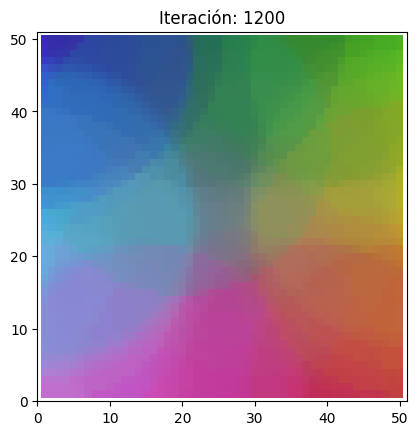

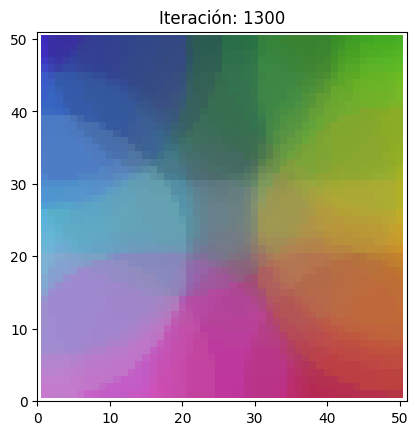

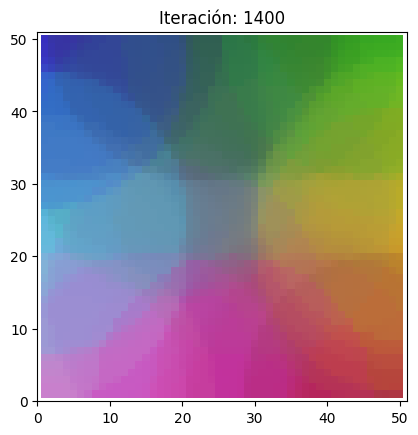

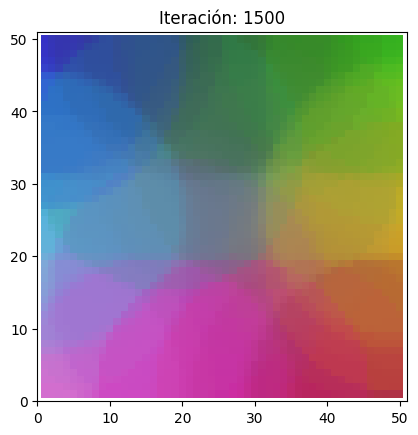

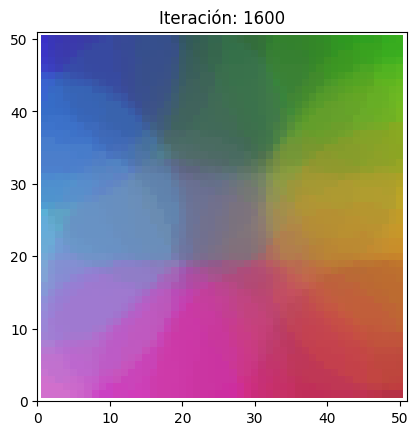

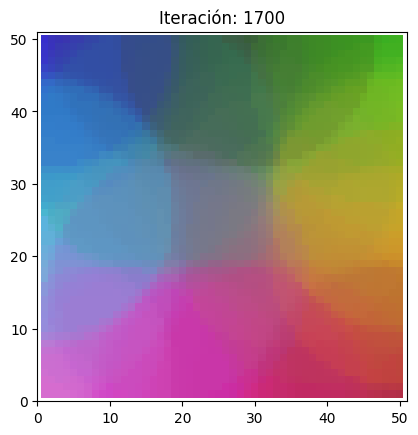

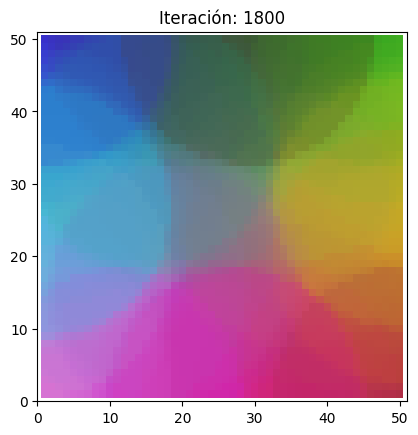

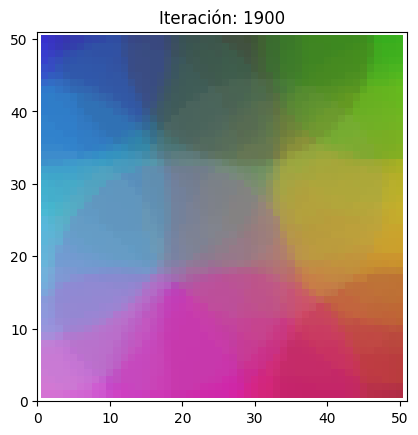

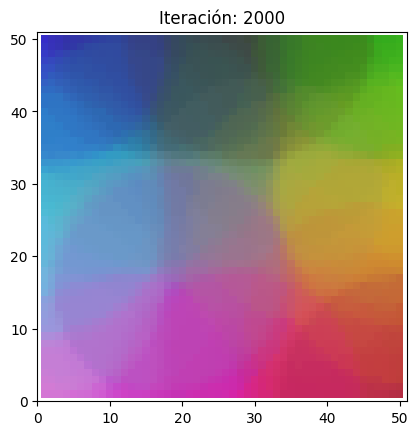

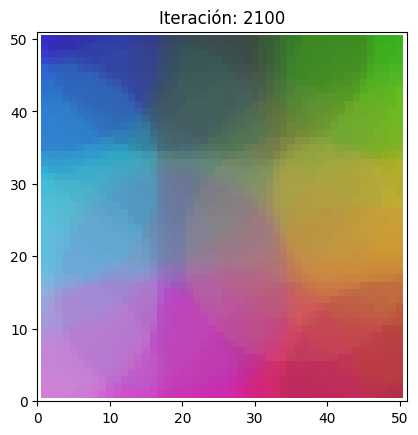

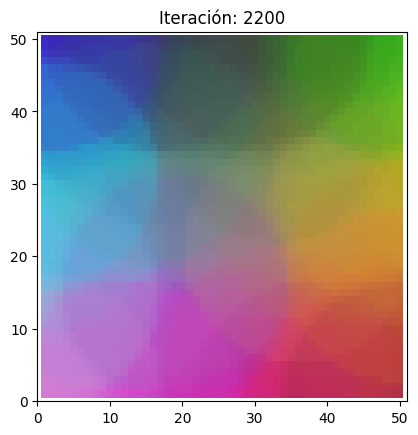

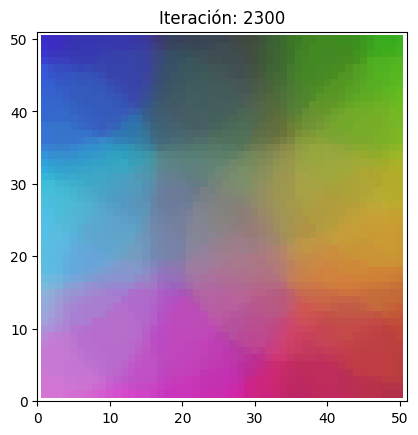

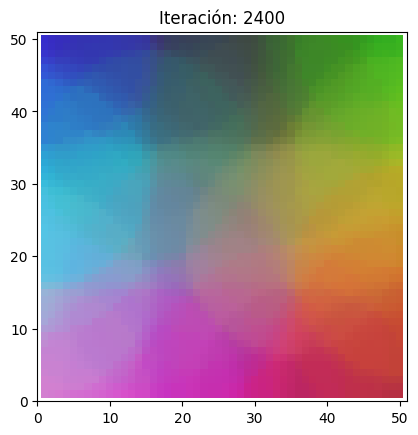

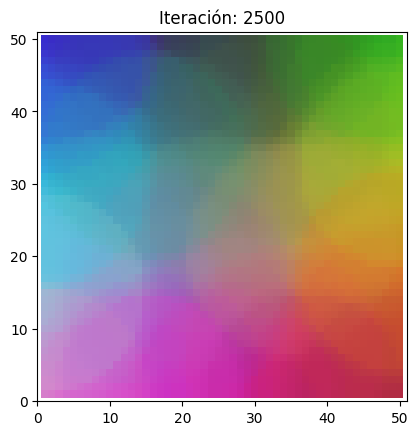

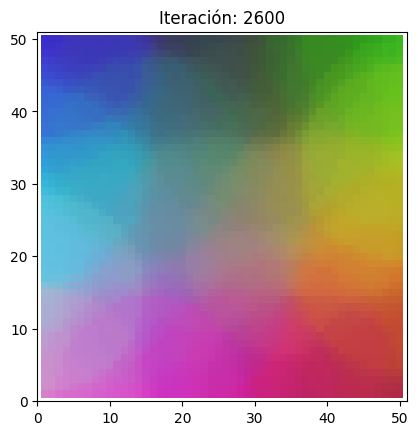

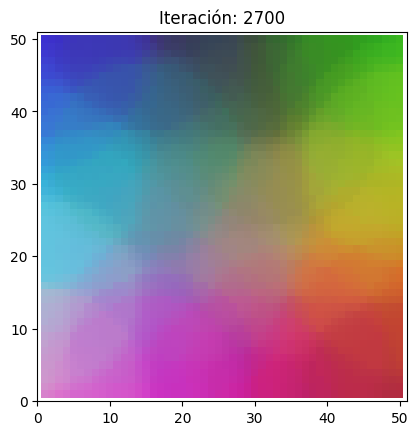

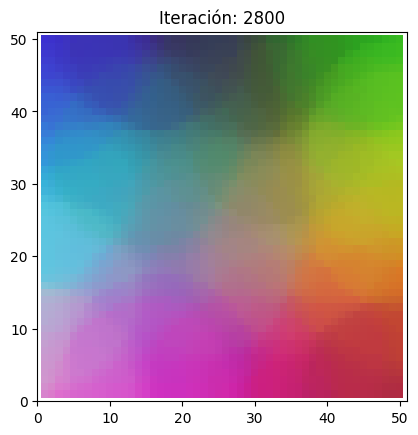

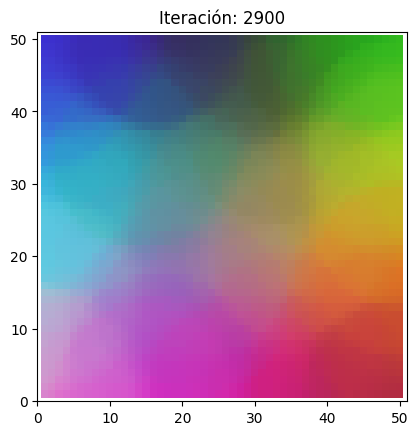

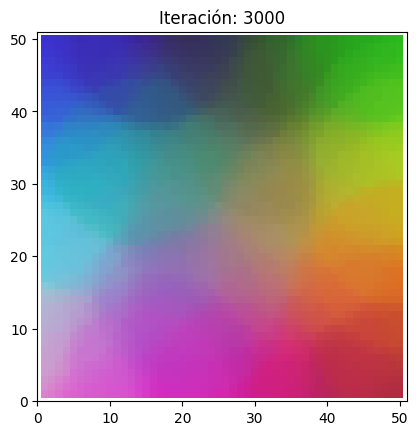

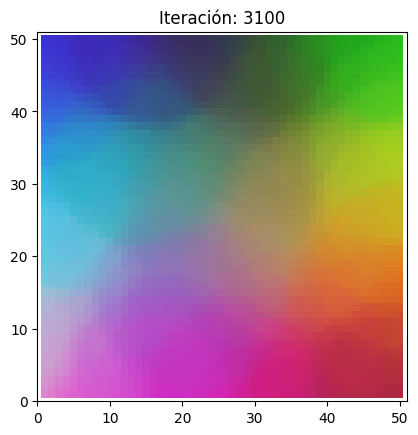

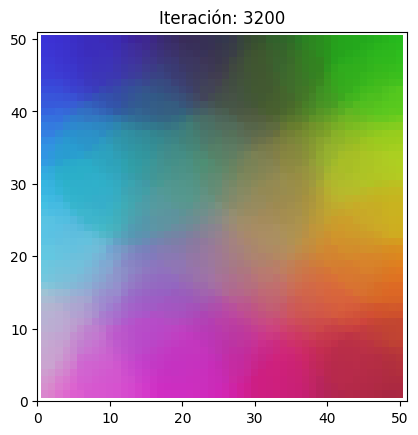

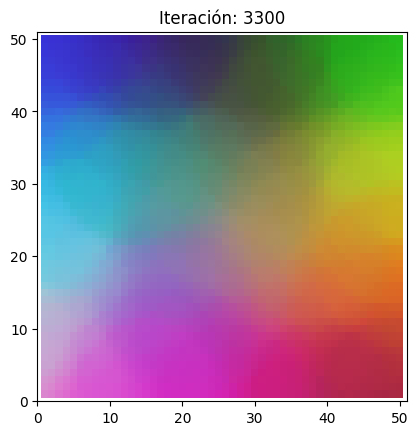

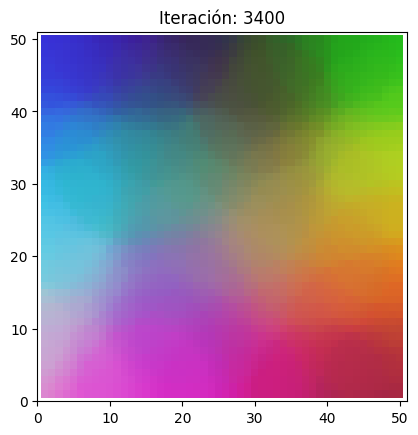

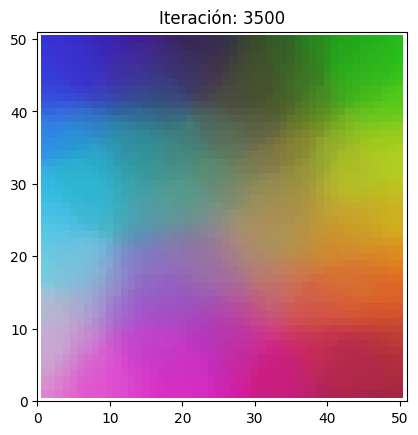

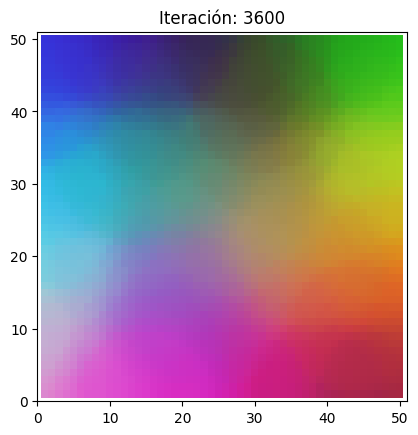

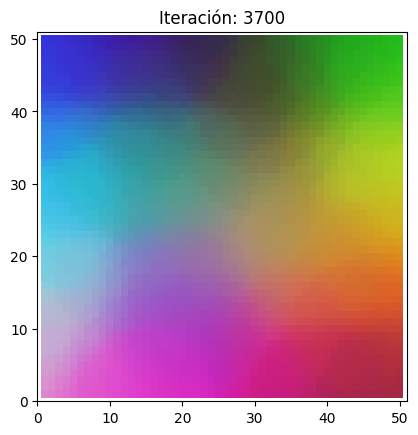

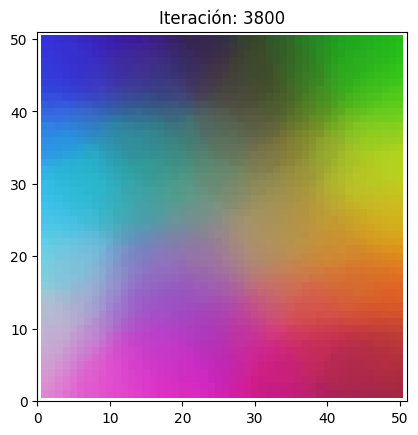

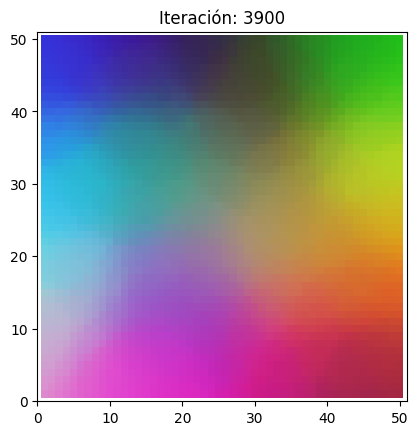

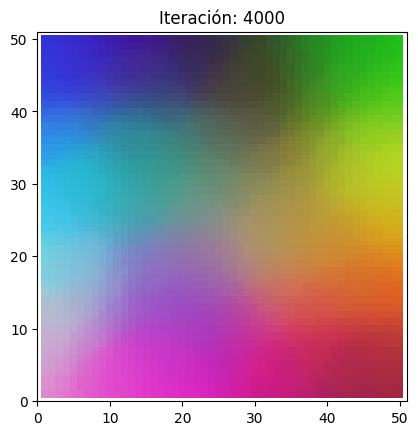

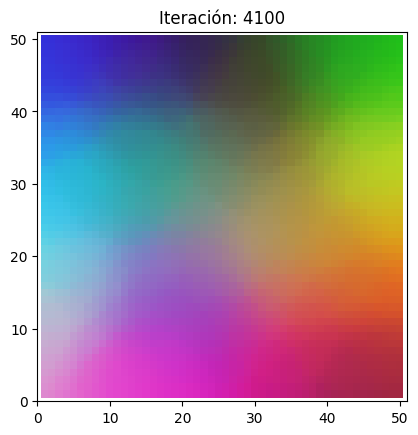

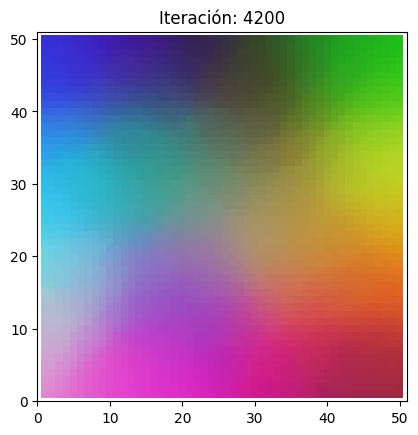

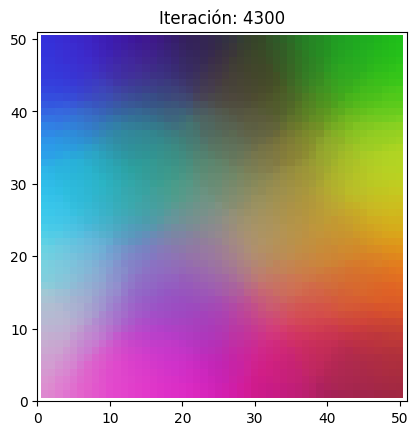

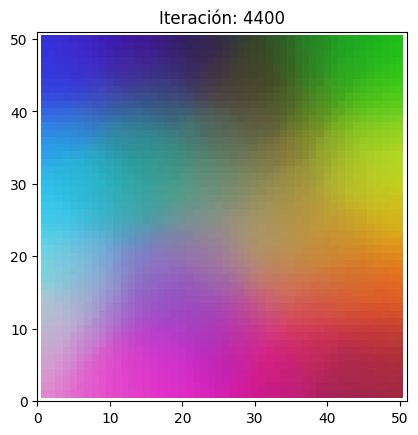

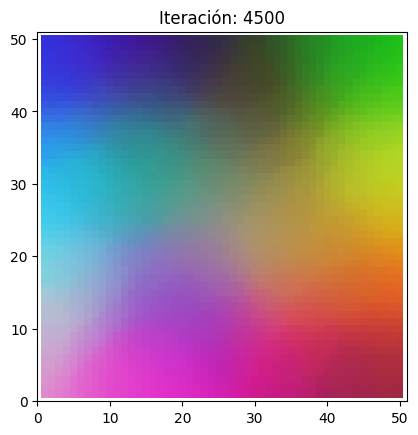

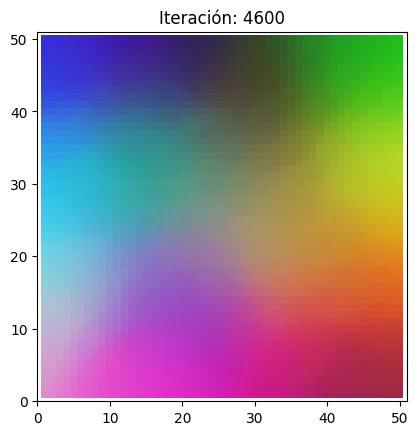

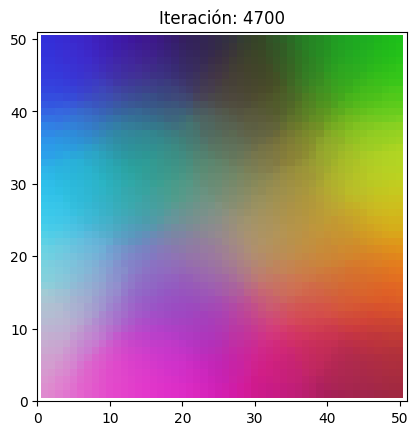

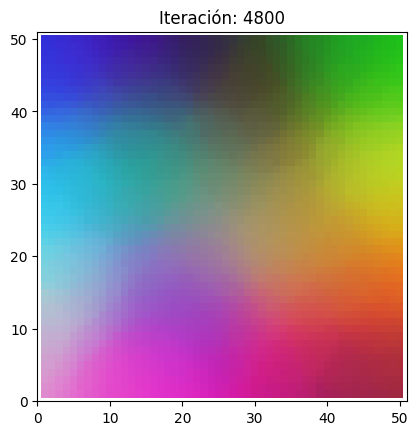

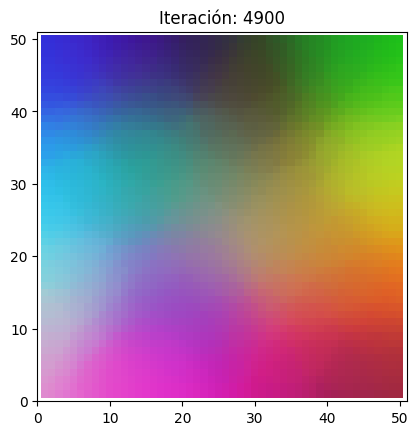

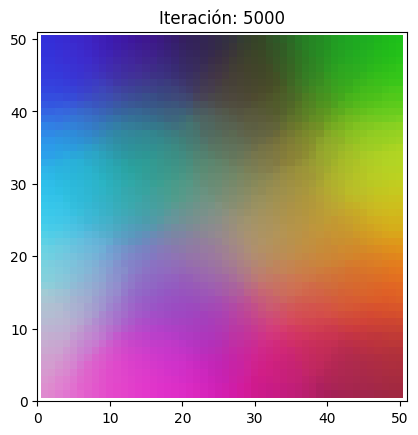

In [32]:
def evaluar_parametros_som(datos, num_datos, num_entradas):
    """Evalúa diferentes combinaciones de parámetros para encontrar los óptimos
    usando rangos automáticos

    Args:
        datos: Datos de entrada (3 x num_datos)
        num_datos: Número de datos de entrada
        num_entradas: Dimensionalidad de los datos de entrada (3 para RGB)

    Returns:
        _type_: _description_
    """

    # Definimos los rangos de parámetors que vamos a evaluar
    rangos_parametros = {
        'lado_mapa': [25, 50, 100],
        'periodo': list(range(1000, 5001, 1000)),
        'learning_rate': [round(x/100, 2) for x in range(1, 6)]
    }

    print("--- Rangos a evaluar: ---")
    print(f"Lados del mapa: {list(rangos_parametros['lado_mapa'])}")
    print(f"Periodos: {list(rangos_parametros['periodo'])}")
    print(f"Learning rates: {rangos_parametros['learning_rate']}")

    # Guardamos los resultados
    resultados = []

    #  Vamos a calcular cuantas combinaciones de parámetros vamos a probar
    total_combinaciones = (len(list(rangos_parametros['lado_mapa'])) *
                            len(list(rangos_parametros['periodo'])) *
                            len(rangos_parametros['learning_rate']))

    print(f"\n Vamos a evaluar {total_combinaciones} combinaciones de parámetros...")

    # Iteramos sobre todas las combinaciones de parámetros
    for indice, (lado, periodo, learning_rate) in enumerate(product(
                                                    rangos_parametros['lado_mapa'],
                                                    rangos_parametros['periodo'],
                                                    rangos_parametros['learning_rate']), 1):

        print(f"\nCombinación {indice}/{total_combinaciones}")
        # print(f"Lado: {lado}, Periodo: {periodo}, Learning Rate: {learning_rate}")

        # Inicializamos la matriz de pesos y el vecindario
        matriz_pesos = np.random.random((lado, lado, num_entradas))
        vecindario = lado // 2

        # Entrenamos el SOM
        matriz_pesos_final = matriz_pesos.copy()
        entrenar_datos(matriz_pesos_final,
                        periodo,
                        datos,
                        num_datos,
                        num_entradas,
                        learning_rate,
                        vecindario)

        # Calculamos el error de cuantificación
        error_total = 0
        for dato in range(num_datos):
            patron = datos[:, dato]
            _, bmu_idx = calcular_bmu(patron, matriz_pesos_final, num_entradas)
            error = np.linalg.norm(patron - matriz_pesos_final[bmu_idx[0], bmu_idx[1]])
            error_total += error

        error_cuantificacion = error_total / num_datos

        # print(f"Error medio/cuantificación: {error_cuantificacion:.6f}")

        # Calculamos el error topológico
        errores_topologicos = 0
        for i in range(num_datos):
            patron = datos[:, i]

            # Primera BMU
            _, bmu1_idx = calcular_bmu(patron, matriz_pesos_final, num_entradas)

            # Calculamos la segunda BMU ignorando la BMU principal
            distancias = np.array([
                (fila, columna, np.linalg.norm(patron - matriz_pesos_final[fila, columna]))
                for fila in range(matriz_pesos_final.shape[0])
                for columna in range(matriz_pesos_final.shape[1])
                if (fila, columna) != tuple(bmu1_idx)
            ])
            distancias = distancias[np.argsort(distancias[:, 2])]  # Ordenamos por distancia
            bmu2_idx = distancias[0, :2]  # Segunda BMU

            # Verificamos si son adyacentes
            distancia = np.linalg.norm(np.array(bmu1_idx) - np.array(bmu2_idx))
            if distancia > np.sqrt(2):  # No son adyacentes
                errores_topologicos += 1

        error_topologico = errores_topologicos / num_datos

        # print(f"Error topológico: {error_topologico:.6f}")

        # Guardamos resultados
        resultados.append({
            'lado_mapa': lado,
            'periodo': periodo,
            'learning_rate': learning_rate,
            'error_cuantificacion': error_cuantificacion,
            'error_topologico': error_topologico
        })


    # Normalizamos los errores para que tengan el mismo peso
    min_cuantificacion = min(r['error_cuantificacion'] for r in resultados)
    max_cuantificacion = max(r['error_cuantificacion'] for r in resultados)
    min_topologico = min(r['error_topologico'] for r in resultados)
    max_topologico = max(r['error_topologico'] for r in resultados)

    def normalizar(valor, min_val, max_val):
        return (valor - min_val) / (max_val - min_val) if max_val > min_val else 0

    # Seleccionamos el mejor resultado considerando ambos errores
    mejor_resultado = min(resultados, key=lambda x: (
        normalizar(x['error_cuantificacion'], min_cuantificacion, max_cuantificacion) +
        normalizar(x['error_topologico'], min_topologico, max_topologico)
    ))

    # Visualizamos los resultados
    visualizar_resultados(resultados)

    return mejor_resultado


def visualizar_resultados(resultados):
    """Visualiza los resultados de la búsqueda de parámetros

    Args:
        resultados: Resultados a visualizar
    """
    resultados_array = np.array([(r['lado_mapa'], r['periodo'],
                                r['learning_rate'], r['error_cuantificacion'],
                                r['error_topologico'])
                                for r in resultados])

    fig = plt.figure(figsize=(15, 5))

    # Gráfico 1: Lado vs Error Cuantificación
    ax1 = fig.add_subplot(231)
    for lr in np.unique(resultados_array[:, 2]):
        mask = resultados_array[:, 2] == lr
        ax1.plot(resultados_array[mask, 0],
                resultados_array[mask, 3],
                'o-',
                label=f'LR={lr}')
    ax1.set_xlabel('Lado del Mapa')
    ax1.set_ylabel('Error de Cuantificación')
    ax1.legend()
    ax1.grid(True)

    # Gráfico 2: Periodo vs Error Cuantificación
    ax2 = fig.add_subplot(232)
    for lr in np.unique(resultados_array[:, 2]):
        mask = resultados_array[:, 2] == lr
        ax2.plot(resultados_array[mask, 1],
                resultados_array[mask, 3],
                'o-',
                label=f'LR={lr}')
    ax2.set_xlabel('Periodo')
    ax2.set_ylabel('Error de Cuantificación')
    ax2.legend()
    ax2.grid(True)

    # Gráfico 3: Learning Rate vs Error Cuantificación
    ax3 = fig.add_subplot(233)
    for lado in np.unique(resultados_array[:, 0]):
        mask = resultados_array[:, 0] == lado
        ax3.plot(resultados_array[mask, 2],
                resultados_array[mask, 3],
                'o-',
                label=f'Lado={int(lado)}')
    ax3.set_xlabel('Learning Rate')
    ax3.set_ylabel('Error de cuantificación')
    ax3.legend()
    ax3.grid(True)

    # Gráfico 4: Lado vs Error Topológico
    ax4 = fig.add_subplot(234)
    for lr in np.unique(resultados_array[:, 2]):
        mask = resultados_array[:, 2] == lr
        ax4.plot(resultados_array[mask, 0],
                resultados_array[mask, 4],
                'o-',
                label=f'LR={lr}')
    ax4.set_xlabel('Lado del Mapa')
    ax4.set_ylabel('Error Topológico')
    ax4.legend()
    ax4.grid(True)

    # Gráfico 5: Periodo vs Error Topológico
    ax5 = fig.add_subplot(235)
    for lr in np.unique(resultados_array[:, 2]):
        mask = resultados_array[:, 2] == lr
        ax5.plot(resultados_array[mask, 1],
                resultados_array[mask, 4],
                'o-',
                label=f'LR={lr}')
    ax5.set_xlabel('Periodo')
    ax5.set_ylabel('Error Topológico')
    ax5.legend()
    ax5.grid(True)

    # Gráfico 6: Learning Rate vs Error Topológico
    ax6 = fig.add_subplot(236)
    for lado in np.unique(resultados_array[:, 0]):
        mask = resultados_array[:, 0] == lado
        ax6.plot(resultados_array[mask, 2],
                resultados_array[mask, 4],
                'o-',
                label=f'Lado={int(lado)}')
    ax6.set_xlabel('Learning Rate')
    ax6.set_ylabel('Error Topológico')
    ax6.legend()
    ax6.grid(True)

    plt.tight_layout()
    plt.show()

# mejor_resultado = evaluar_parametros_som(datos, num_datos, num_entradas)

# print("\nMejores parámetros encontrados:")
# print(f"Lado del mapa: {mejor_resultado['lado_mapa']}")
# print(f"Periodo: {mejor_resultado['periodo']}")
# print(f"Learning rate: {mejor_resultado['learning_rate']}")
# print(f"Error de cuantificación: {mejor_resultado['error_cuantificacion']:.10f}")
# print(f"Error topológico: {mejor_resultado['error_topologico']:.10f}")

# # Guardamos los mejores parámetros para su uso posterior
# parametros_optimos = {
#     'lado_mapa': mejor_resultado['lado_mapa'],
#     'periodo': mejor_resultado['periodo'],
#     'learning_rate': mejor_resultado['learning_rate'],
#     'vecindario': mejor_resultado['lado_mapa'] // 2
# }

parametros_optimos = {
    'lado_mapa': 50,
    'periodo': 5000,
    'learning_rate': 0.05,
    'vecindario': 50 // 2
}

matriz_pesos_inicial = np.random.random((parametros_optimos['lado_mapa'], parametros_optimos['lado_mapa'], num_entradas))
matriz_pesos_mejores_parametros_inicial = np.copy(matriz_pesos_inicial)

matriz_pesos_mejores_parametros = entrenar_datos(matriz_pesos_inicial, parametros_optimos['periodo'], datos, num_datos, num_entradas, parametros_optimos['learning_rate'], parametros_optimos['vecindario'])


## SOM Clasificación

Una vez que hemos entrenado nuestro SOM, podemos usarlo para clasificar nuevos datos asignándolos a las neuronas que mejor representan sus características. Este proceso se basa en buscar la BMY para cada nuevo dato (como en el entrenamiento) y asignarle la etiqueta de la neurona ganadora.

Con un nuevo vector de entrada, la clasificación se hace de la siguiente forma:
1. **Cálculo de la BMU** $\rightarrow$ Buscamos la neurona con el vector de pesos más cercano al vector de entrada, minimizando la distancia euclídea.
2. **Asignación de la clase** $\rightarrow$ Asignamos la clase de la BMU al dato de entrada.
3. **Visualización** $\rightarrow$ Podemos construir diferentes mapas para analizar el comportamiento de la clasificación y la estructura de los datos.

El número de clases hace referencia a la cantidad de diferentes categorías que han sido asignadas/identificadas. Las clases nos permiten verificar si el SOM ha identificado correctamente la cantidad esperada de categorías en los datos y en problemas sin etiquetas, nos ayuda a entender la estructura de los datos y ver patrones ocultos. 
* En un problema supervisado, el número de clases es igual al número de etiquetas.
* En un problema no supervisado, el número de clases es igual al número de grupos identificados por el SOM.

Como hemos explicado anteriormente, después del entrenamiento y la clasificación, podemos  generar diferentes mapas de análisis/salida para interpretar los resultados.
* **Mapa de clasificación** $\rightarrow$ Muestra la distribución de las clases asignadas en el mapa. 
  * Cada neurona se colorea según la clase mayoritaria de los datos que representa.
* **Mapa de activaciones** $\rightarrow$ Este mapa nos muesta cuántos datos han sido asignados a cada neurona. 
  * Es útil para ver cómo de bien se ha ajustado el SOM a los datos de entrada. 
  * Cada celda del mapa representa una neurona y su activación se mide por la cantidad de veces que fue seleccionada como BMU.
  * Zonas con muchas activaciones indican que la neurona representa bien los datos.
  * Zonas con pocas activaciones pueden sugerir regiones subutilizadas o datos poco representativos.
* **Mapa de distancias** $\rightarrow$ Representa la distancia media entre los pesos de una neurona y sus vecinas.
  * Zonas de baja distancia indican grupos de neuronas similares.
  * Zonas de alta distancia indican fronteras entre grupos.
  * Es útil para ver e identificar fronteras naturales entre categorías.
  * Nos ayuda a ver si los datos est'an bien separados o si hay regiones de transición.


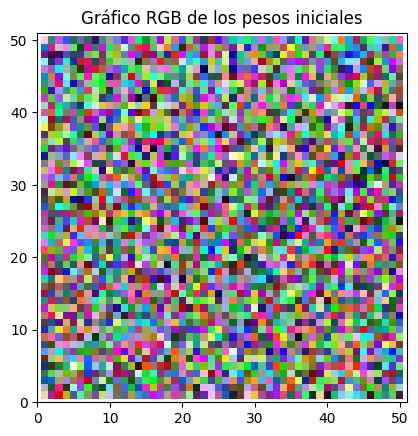

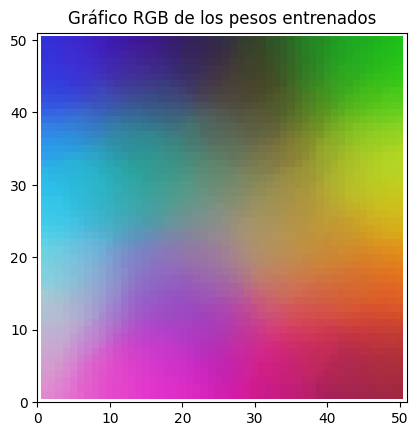

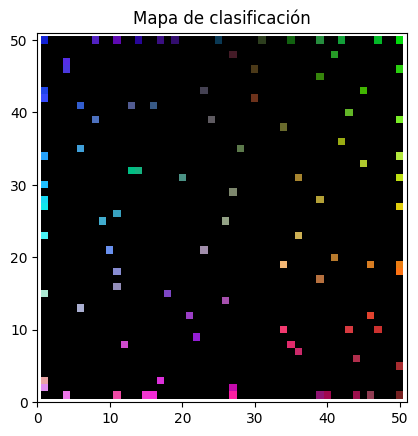

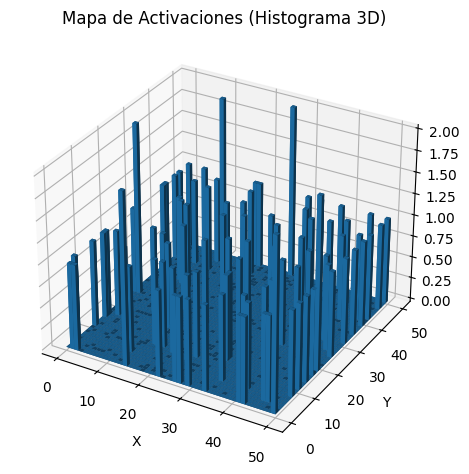

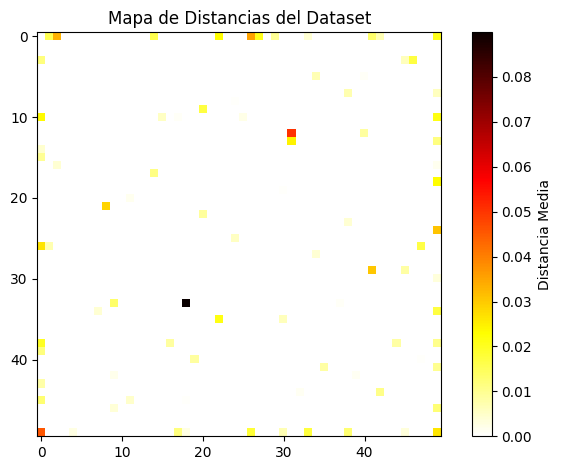

Número de clases identificadas: 94
Error de Cuantificación: 0.011855
Error Topológico: 0.020000


In [33]:
def clasificar_som(datos, matriz_pesos, calcular_bmu):
    """Clasifica un dataset de patrones usando una matriz de pesos entrenada.

    Args:
        datos: Datos de entrada (num_entradas x num_patrones)
        matriz_pesos: Matriz de pesos entrenada (lado_mapa x lado_mapa x num_entradas)
        calcular_bmu: Función para calcular la BMU

    Returns:
        tuple (mapa_clasificacion, mapa_activaciones, mapa_distancias, num_clases, error_cuantificacion, error_topologico):
            - mapa_clasificacion: Matriz con los patrones clasificados por cada neurona (lado_mapa x lado_mapa x num_entradas)
            - mapa_activaciones: Matriz con el número de patrones reconocidos por cada neurona (lado_mapa x lado_mapa)
            - mapa_distancias: Matriz con la distancia media de los patrones con el vector de pesos (lado_mapa x lado_mapa)
            - num_clases: Número de clases identificadas
            - error_cuantificacion: Error de cuantificación
            - error_topologico: Error topológico
    """

    # Obtenemos las dimensiones de la matriz de pesos
    # y los patrones de entrada
    filas = matriz_pesos.shape[0]
    columnas = matriz_pesos.shape[1]
    dim_entrada = matriz_pesos.shape[2]
    num_patrones = datos.shape[1]  # Número de patrones (segunda dimensión de datos)

    # 1. Definimos las tres matrices y las inicializamos a 0
    # Mapa de clasificación: Guarda el último patrón clasificado en cada neurona
    mapa_clasificacion = np.zeros([filas, columnas, dim_entrada])

    # Mapa de activaciones: Guarda el número de patrones reconocidos por cada neurona
    mapa_activaciones = np.zeros([filas, columnas])

    # Mapa de distancias: Guarda la distancia media de los patrones con el vector de pesos
    mapa_distancias = np.zeros([filas, columnas])

    # Sumas totales de cada error
    suma_error_cuantificacion = 0
    suma_error_topologico = 0

    # 2. Recorremos todo el dataset de patrones de entrada
    for patron in range(num_patrones):
        # Obtenemos el patrón actual para clasificar
        patron_actual = datos[:, patron]  # Extraemos el patrón (columna) actual

        # Calculamos la BMU para el patrón actual
        vector_bmu, coords_bmu = calcular_bmu(patron_actual, matriz_pesos, dim_entrada)
        fila_bmu, col_bmu = coords_bmu

        # Calculamos la distancia entre el patrón actual y la BMU actual (error de cuantificación)
        distancia_patron_bmu = np.linalg.norm(matriz_pesos[int(fila_bmu), int(col_bmu)] - patron_actual)**2

        # Actualizamos el mapa de clasificación con el patrón actual
        if mapa_activaciones[int(fila_bmu), int(col_bmu)] == 0:
            mapa_clasificacion[int(fila_bmu), int(col_bmu)] = patron_actual
        else:
            mapa_clasificacion[int(fila_bmu), int(col_bmu)] = (
                (mapa_clasificacion[int(fila_bmu), int(col_bmu)] * mapa_activaciones[int(fila_bmu), int(col_bmu)] + patron_actual) /
                (mapa_activaciones[int(fila_bmu), int(col_bmu)] + 1)
            )

        # Incrementamos el contador de activaciones de la BMU
        mapa_activaciones[int(fila_bmu), int(col_bmu)] += 1

        # Añadimos la distancia entre el patrón y la BMU al mapa de distancias
        mapa_distancias[int(fila_bmu), int(col_bmu)] = (
            (mapa_distancias[int(fila_bmu), int(col_bmu)] * (mapa_activaciones[int(fila_bmu), int(col_bmu)] - 1) + distancia_patron_bmu) /
            mapa_activaciones[int(fila_bmu), int(col_bmu)]
        )

        # Añadimos el error de cuantificación al total
        suma_error_cuantificacion += distancia_patron_bmu

        # Calculamos el error topológico
        # Calculamos las distancias a todas las neuronas para el patrón actual
        distancias = np.zeros([filas, columnas])
        for fila in range(filas):
            for columna in range(columnas):
                distancias[fila, columna] = np.linalg.norm(matriz_pesos[fila, columna] - patron_actual)**2

        # Marcamos la BMU como infinito para encontrar la segunda BMU
        # Encontramos la segunda BMU utilizando la misma estrategia que en Forma 1
        distancias_lista = np.array([
            (fila, columna, np.linalg.norm(matriz_pesos[fila, columna] - patron_actual))
            for fila in range(filas)
            for columna in range(columnas)
            if (fila, columna) != (fila_bmu, col_bmu)  # Excluir la BMU principal
        ])
        distancias_lista = distancias_lista[np.argsort(distancias_lista[:, 2])]  # Ordenar por distancia
        bmu2_idx = distancias_lista[0, :2]  # Segunda BMU más cercana
        fila_bmu2, col_bmu2 = int(bmu2_idx[0]), int(bmu2_idx[1])

        # Comprobamos si las dos BMUs son adyacentes
        if (abs(fila_bmu - fila_bmu2) <= 1 and abs(col_bmu - col_bmu2) <= 1):
            # Son adyacentes - no hay error topológico
            suma_error_topologico += 0
        else:
            # No son adyacentes - hay error topológico
            suma_error_topologico += 1

    # Calculamos el número de clases (neuronas activadas)
    num_clases = np.count_nonzero(mapa_activaciones)

    # Calculamos los errores medios
    error_cuantificacion = suma_error_cuantificacion / num_patrones
    error_topologico = suma_error_topologico / num_patrones

    return mapa_clasificacion, mapa_activaciones, mapa_distancias, num_clases, error_cuantificacion, error_topologico

mapa_clasificacion, mapa_activaciones, mapa_distancias, num_clases, error_cuantificacion, error_topologico = clasificar_som(datos, matriz_pesos_mejores_parametros, calcular_bmu)

# 1. Mostramos el Gráfico RGB de los pesos iniciales
pintar_mapa(matriz_pesos_mejores_parametros_inicial, "Gráfico RGB de los pesos iniciales")

# 2. Mostramos el Gráfico RGB de los pesos entrenados
pintar_mapa(matriz_pesos_mejores_parametros, "Gráfico RGB de los pesos entrenados")

# 3. Mostramos el mapa de clasificación
pintar_mapa(mapa_clasificacion, "Mapa de clasificación")

# 4 Mostramos el histograma 3D del Mapa de Activaciones
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x = np.arange(mapa_activaciones.shape[0])
y = np.arange(mapa_activaciones.shape[1])
X, Y = np.meshgrid(x, y)
ax.bar3d(X.ravel(), Y.ravel(), np.zeros_like(mapa_activaciones).ravel(),
            1, 1, mapa_activaciones.ravel(), shade=True)
ax.set_title("Mapa de Activaciones (Histograma 3D)")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Frecuencia")
ax.set_zlabel("Frecuencia", labelpad=10)
plt.tight_layout()
plt.show()

# 5. Mostramos el mapa de distancias
plt.figure()
plt.title("Mapa de Distancias del Dataset")
im = plt.imshow(mapa_distancias, cmap='hot_r')
plt.colorbar(im, label="Distancia Media")
plt.tight_layout()
plt.show()

# 6. Número de clases y errores
print(f"Número de clases identificadas: {num_clases}")
print(f"Error de Cuantificación: {error_cuantificacion:.6f}")
print(f"Error Topológico: {error_topologico:.6f}")

## SOM Prueba

El proceso de prueba es la fase en la que evaluamos cómo se comporta la red con datos nuevos después del entrenamiento. En esta fase, no actualizamos los pesos, si no que analizamos cómo la red clasifica los nuevos datos.

Los objetivos de la fase de prueba son:
* **Evaluar la calidad de la clasificación** $\rightarrow$ Verificar si la red ha aprendido correctamente las características de los datos y es capaz de generalizar y organizar nuevos datos.
* **Observar la estructura de los datos** $\rightarrow$ Ver cómo los patrones de entrada se asignan a las neuronas y cómo se organizan en el mapa.
* **Identificar errores** $\rightarrow$ Ver si hay datos mal clasificados y entender por qué la red ha cometido errores utilizando el error de cuantificación y el error topológico.

Como hemos mencionado anteriormente, en la fase de prueba no se actualizan los pesos del SOM. Los pasos a seguir son:
1. **Presentación de nuevos datos** $\rightarrow$ Presentamos un conjunto nuevo de datos que el SOM no ha visto durante el entrenamiento. Cada dato de entrada es un vector de características similares a los datos de entrenamiento.
2. **Cálculo de la BMU** $\rightarrow$ Para cada dato de entrada, buscamos la mejor neurona (BMU) que representa mejor las características del dato.
3. **Asignación de la clase** $\rightarrow$ Asignamos qué neurona del SOM ha reconocido cada dato. 
4. **Análisis de los resultados** $\rightarrow$ Analizamos cómo se han clasificado los datos y si hay errores mediante el error topológico (indica si los datos similares se asignan a neuronas adyacentes) y el mapa de clasificación (muestra dónde se han asignado los datos de prueba en el som).

Las diferencias entre las fases de entrenamiento, clasificación y prueba son las siguientes:

| **Fase**                        | **SOM de Entrenamiento**            | **SOM de Clasificación**                    | **SOM de Prueba**                       |
|---------------------------------|-------------------------------------|---------------------------------------------|-----------------------------------------|
| **Se le muestran datos nuevos** | No (usa datos de entrenamiento)     | No (usa los mismos datos del entrenamiento) | Sí (se prueban datos no vistos)         |
| **Modifica pesos**              | Sí (ajusta los pesos)               | No (solo asigna patrones)                   | No (solo analiza datos nuevos)          |
| **Encuentra BMU**               | Sí                                  | Sí                                          | Sí                                      |
| **Ajusta la vecindad**          | Sí (disminuye con el tiempo)        | No                                          | No                                      |
| **Calcula errores**             | Sí (para optimizar el aprendizaje)  | Sí (para evaluar la clasificación)          | Sí (para medir la generalización)       |
| **Objetivo**                    | Aprender la estructura de los datos | Organizar datos entrenados                  | Evaluar el rendimiento con datos nuevos |



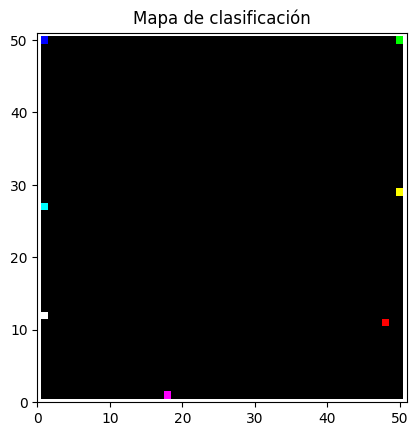

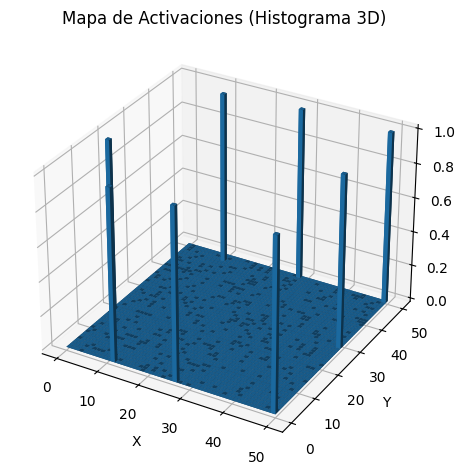

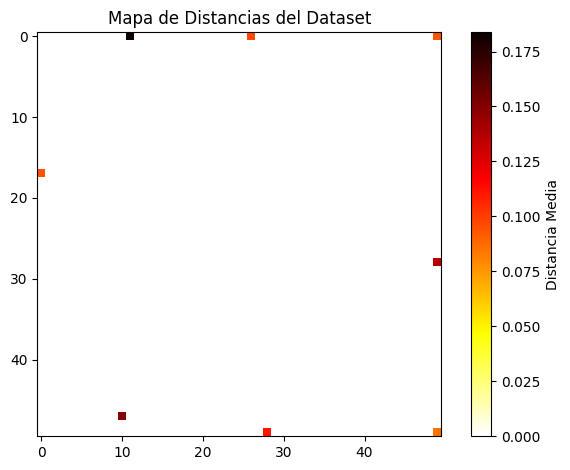

Número de clases identificadas: 8
Error de Cuantificación: 0.118587
Error Topológico: 0.125000


In [36]:
def probar_som(datos_prueba, matriz_pesos, calcular_bmu):
    """Prueba el SOM con datos nuevos y mide su rendimiento.

    Args:
        datos_prueba: Datos de prueba (num_entradas x num_patrones)
        matriz_pesos: Matriz de pesos entrenada (lado_mapa x lado_mapa x num_entradas)
        calcular_bmu: Función para calcular la BMU

    Returns:
        tuple (mapa_prueba, mapa_activaciones_prueba, mapa_distancias_prueba,
               error_cuantificacion_prueba, error_topologico_prueba):
            - mapa_prueba: Mapa de clasificación de los datos de prueba
            - mapa_activaciones_prueba: Mapa con el número de activaciones por neurona
            - mapa_distancias_prueba: Mapa con la distancia media de los datos de prueba a sus BMUs
            - error_cuantificacion_prueba: Error de cuantificación en la prueba
            - error_topologico_prueba: Error topológico en la prueba
    """

    # Obtenemos las dimensiones de la matriz de pesos
    # y los datos de prueba
    filas = matriz_pesos.shape[0]
    columnas = matriz_pesos.shape[1]
    dim_entrada = matriz_pesos.shape[2]
    num_patrones = datos_prueba.shape[1]  # Número de patrones en los datos de prueba

    # 1. definimos las tres matrices y las inicializamos a 0
    # Mapa de prueba (clasificación): Guarda el último patrón clasificado en cada neurona
    mapa_prueba = np.zeros([filas, columnas, dim_entrada])

    # Mapa de activaciones: Guarda el número de patrones reconocidos por cada neurona
    mapa_activaciones_prueba = np.zeros([filas, columnas])

    # Mapa de distancias: Guarda la distancia media de los patrones con el vector de pesos
    mapa_distancias_prueba = np.zeros([filas, columnas])

    # Sumas totales de cada error
    suma_error_cuantificacion = 0
    suma_error_topologico = 0

    # 2. Recorremos todos los patrones de prueba
    for patron in range(num_patrones):
        # Obtenemos el patrón actual para clasificar
        patron_actual = datos_prueba[:, patron]

        # Calculamos la BMU para el patrón actual
        vector_bmu, coords_bmu = calcular_bmu(patron_actual, matriz_pesos, dim_entrada)
        fila_bmu, col_bmu = coords_bmu

        # Calculamos la distancia entre el patrón actual y la BMU actual (error de cuantificación)
        distancia_patron_bmu = np.linalg.norm(matriz_pesos[int(fila_bmu), int(col_bmu)] - patron_actual)**2

        # Actualizamos el mapa de clasificación con el patrón actual
        if mapa_activaciones_prueba[int(fila_bmu), int(col_bmu)] == 0:
            mapa_prueba[int(fila_bmu), int(col_bmu)] = patron_actual
        else:
            mapa_prueba[int(fila_bmu), int(col_bmu)] = (
                (mapa_prueba[int(fila_bmu), int(col_bmu)] * mapa_activaciones_prueba[int(fila_bmu), int(col_bmu)] + patron_actual) /
                (mapa_activaciones_prueba[int(fila_bmu), int(col_bmu)] + 1)
            )

        # Incrementamos el contador de activaciones de la BMU
        mapa_activaciones_prueba[int(fila_bmu), int(col_bmu)] += 1

        # Actualizamos el mapa de distancias
        # Añadimos la distancia entre el patrón y la BMU al mapa de distancias
        mapa_distancias_prueba[int(fila_bmu), int(col_bmu)] = (
            (mapa_distancias_prueba[int(fila_bmu), int(col_bmu)] * (mapa_activaciones_prueba[int(fila_bmu), int(col_bmu)] - 1) + distancia_patron_bmu) /
            mapa_activaciones_prueba[int(fila_bmu), int(col_bmu)]
        )

        # Añadimos el error de cuantificación al total
        suma_error_cuantificacion += distancia_patron_bmu

        # Calculamos el error topológico
        # Calculamos las distancias a todas las neuronas para el patrón actual
        distancias = np.zeros([filas, columnas])
        for fila in range(filas):
            for columna in range(columnas):
                distancias[fila, columna] = np.linalg.norm(matriz_pesos[fila, columna] - patron_actual)**2

        # Marcamos la BMU como infinito para encontrar la segunda BMU
        # Encontramos la segunda BMU utilizando la misma estrategia que en Forma 1
        distancias_lista = np.array([
            (fila, columna, np.linalg.norm(matriz_pesos[fila, columna] - patron_actual))
            for fila in range(filas)
            for columna in range(columnas)
            if (fila, columna) != (fila_bmu, col_bmu)  # Excluir la BMU principal
        ])
        distancias_lista = distancias_lista[np.argsort(distancias_lista[:, 2])]  # Ordenar por distancia
        bmu2_idx = distancias_lista[0, :2]  # Segunda BMU más cercana
        fila_bmu2, col_bmu2 = int(bmu2_idx[0]), int(bmu2_idx[1])

        # Comprobamos si las dos BMUs son adyacentes
        if (abs(fila_bmu - fila_bmu2) <= 1 and abs(col_bmu - col_bmu2) <= 1):
            # Son adyacentes - no hay error topológico
            suma_error_topologico += 0
        else:
            # No son adyacentes - hay error topológico
            suma_error_topologico += 1

    # Calculamos el número de clases (neuronas activadas)
    num_clases = np.count_nonzero(mapa_activaciones_prueba)

    # Cálculo de errores medios
    error_cuantificacion_prueba = suma_error_cuantificacion / num_patrones
    error_topologico_prueba = suma_error_topologico / num_patrones


    return mapa_prueba, mapa_activaciones_prueba, mapa_distancias_prueba, num_clases, error_cuantificacion_prueba, error_topologico_prueba

# Definimos los colores específicos para probar
colores_prueba = np.array([
    [255, 255, 255],  # Blanco
    [255, 0, 0],      # Rojo
    [0, 255, 0],      # Verde
    [0, 0, 255],      # Azul
    [255, 255, 0],    # Amarillo
    [255, 0, 255],    # Magenta
    [0, 255, 255],    # Cian
    [0, 0, 0]         # Negro
])

datos_prueba = colores_prueba.T


if normalizar_datos:
    # Escalamos los datos al rango [0, 1]
    datos_prueba = datos_prueba / np.max(valor_maximo)

mapa_prueba, mapa_activaciones_prueba, mapa_distancias_prueba, num_clases_prueba, error_cuantificacion_prueba, error_topologico_prueba = probar_som(datos_prueba, matriz_pesos_mejores_parametros, calcular_bmu)

# 1. Mostramos el mapa de clasificación
pintar_mapa(mapa_prueba, "Mapa de clasificación")

# 2 Mostramos el histograma 3D del Mapa de Activaciones
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x = np.arange(mapa_activaciones_prueba.shape[0])
y = np.arange(mapa_activaciones_prueba.shape[1])
X, Y = np.meshgrid(x, y)
ax.bar3d(X.ravel(), Y.ravel(), np.zeros_like(mapa_activaciones_prueba).ravel(),
            1, 1, mapa_activaciones_prueba.ravel(), shade=True)
ax.set_title("Mapa de Activaciones (Histograma 3D)")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Frecuencia")
ax.set_zlabel("Frecuencia", labelpad=10)
plt.tight_layout()
plt.show()

# 3. Mostramos el mapa de distancias
plt.figure()
plt.title("Mapa de Distancias del Dataset")
im = plt.imshow(mapa_distancias_prueba, cmap='hot_r')
plt.colorbar(im, label="Distancia Media")
plt.tight_layout()
plt.show()

# 6. Número de clases y errores
print(f"Número de clases identificadas: {num_clases_prueba}")
print(f"Error de Cuantificación: {error_cuantificacion_prueba:.6f}")
print(f"Error Topológico: {error_topologico_prueba:.6f}")